In [1]:
from time import time
from enum import Enum

import nest_asyncio
import pandas as pd
import numpy as np
import tensorflow as tf
from pathlib import Path

from keras.layers import Flatten, Dense, Dropout, Conv2D, \
    MaxPool2D
from keras.models import Sequential

nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)
import gc

gc.collect()


2024-06-20 18:35:39.284543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-20 18:35:39.311026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


0

In [2]:

this_dir = Path.cwd()
print(this_dir)

# NUM_FEATURE = len(data_test_without_flow.columns) - 1
NUM_FEATURE = 512
NUM_PACKETS_PER_FLOW = 20
EPOCHS = 30
NUM_CLASSES = 3

EXPERIMENT_NAME = f"MERGE-REAL-{NUM_PACKETS_PER_FLOW}-{NUM_FEATURE}"

print('Number of features: ', NUM_FEATURE, ', Number of classes: ', NUM_CLASSES, ', Number of packets per flow: ',
      NUM_PACKETS_PER_FLOW)

/home/dasvision/dunghv/doh-exfitration-detector
Number of features:  512 , Number of classes:  3 , Number of packets per flow:  10


# Load data

In [3]:

data_dir = this_dir / "dataset" 

class Label(Enum):
    BENIGN = 0
    DNS2TCP = 1
    IODINE = 2


benign_path = data_dir / "benign" / "benign_chrome_google.csv"
benign_flows = 20000
# dnscat2_path = data_dir / "malicious" / "dnscat2.csv"
# dnscat2_flows = 10000
dns2tcp_path = data_dir / "malicious" / "dns2tcp.csv"
dns2tcp_flows = 30000
iodine_path = data_dir / "malicious" / "iodine.csv"
iodine_flows = 12000


def nrows(flow_number):
    return flow_number * NUM_PACKETS_PER_FLOW


benign_data = pd.read_csv(benign_path, nrows=nrows(benign_flows))
benign_data['label'] = Label.BENIGN.value
# dnscat2_data = pd.read_csv(dns2tcp_path, nrows=nrows(dnscat2_flows))
# dnscat2_data['label'] = Label.DNSCAT2.value
dns2tcp_data = pd.read_csv(dns2tcp_path, nrows=nrows(dns2tcp_flows))
dns2tcp_data['label'] = Label.DNS2TCP.value
iodine_data = pd.read_csv(iodine_path, nrows=nrows(iodine_flows))
iodine_data['label'] = Label.IODINE.value

print('benign_data: ' + str(benign_data.groupby('flow_id').size().count()),
    #   ', dnscat2_data: ' + str(dnscat2_data.groupby('flow_id').size().count()),
      ', dns2tcp_data: ' + str(dns2tcp_data.groupby('flow_id').size().count()),
      ', iodine_data: ' + str(iodine_data.groupby('flow_id').size().count()))

benign_data: 20000 , dns2tcp_data: 30000 , iodine_data: 12000


# Split data into train, validate and test

In [4]:
from sklearn.model_selection import GroupShuffleSplit


def split(dataset: pd.DataFrame, split_ratio: float = 0.8) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Split a dataset into a training and test dataset.
    :param dataset: The dataset to split.
    :param split_ratio: The ratio of the split.
    :return: A tuple containing the training and test datasets.
    """
    first_inds, next_inds = next(
        GroupShuffleSplit(train_size=split_ratio, n_splits=2, random_state=42).split(dataset,
                                                                                     groups=dataset['flow_id']))

    return dataset.iloc[first_inds], dataset.iloc[next_inds]

In [5]:
# Split benign data into train, validate and test
train_benign, test_benign = split(benign_data, 0.8)
train_benign, validate_benign = split(train_benign, 0.8)

In [6]:
del benign_data
gc.collect()

0

In [7]:
# train_dnscat2, test_dnscat2 = split(dnscat2_data, 0.8)
# train_dnscat2, validate_dnscat2 = split(train_dnscat2, 0.8)

In [8]:
# del dnscat2_data
# gc.collect()

In [9]:
# Split dns2tcp data into train, validate and test
train_dns2tcp, test_dns2tcp = split(dns2tcp_data, 0.8)
train_dns2tcp, validate_dns2tcp = split(train_dns2tcp, 0.8)

In [10]:
del dns2tcp_data
gc.collect()

0

In [11]:
# Split iodine data into train, validate and test
train_iodine, test_iodine = split(iodine_data, 0.8)
train_iodine, validate_iodine = split(train_iodine, 0.8)

In [12]:
del iodine_data
gc.collect()

0

# Merge data

In [13]:
data_train = pd.concat([train_benign, train_dns2tcp, train_iodine], ignore_index=True, sort=False,
                       axis=0)
data_validate = pd.concat([validate_benign, validate_dns2tcp, validate_iodine], ignore_index=True,
                          sort=False, axis=0)
data_test = pd.concat([test_benign, test_dns2tcp, test_iodine], ignore_index=True, sort=False, axis=0)

# Get label

In [14]:
def most_frequent(flow):
    return max(set(flow), key=flow.count)

In [15]:
def get_label(data):
    grouped = data.groupby('flow_id')['label'].apply(list).to_dict()

    label = []
    for flow in grouped:
        label.append(most_frequent(grouped[flow]))

    return np.array(label)

In [16]:
label_train = np.array(get_label(data_train))
label_validate = np.array(get_label(data_validate))
label_test = np.array(get_label(data_test))

print('Label train: ', len(label_train), ', Label validate: ', len(label_validate), ', Label test: ', len(label_test))

Label train:  39680 , Label validate:  9920 , Label test:  12400


In [17]:
# Drop number of rows per flow to NUM_PACKETS_PER_FLOW
def drop_rows(data):
    return data.groupby('flow_id').head(NUM_PACKETS_PER_FLOW)

data_train = drop_rows(data_train)
data_validate = drop_rows(data_validate)
data_test = drop_rows(data_test)

In [18]:
data_train_without_flow = data_train.drop('flow_id', axis=1)
data_validate_without_flow = data_validate.drop('flow_id', axis=1)
data_test_without_flow = data_test.drop('flow_id', axis=1)

In [19]:
x_train = np.array(
    (data_train_without_flow.drop('label', axis=1).iloc[:, :NUM_FEATURE].to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE))
x_validate = np.expand_dims(
    (data_validate_without_flow.drop('label', axis=1).iloc[:, :NUM_FEATURE].to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE),
    axis=-1)
x_test = np.expand_dims(
    (data_test_without_flow.drop('label', axis=1).iloc[:, :NUM_FEATURE].to_numpy() / 255).reshape(-1, NUM_PACKETS_PER_FLOW, NUM_FEATURE),
    axis=-1)

print('x_train shape: ', x_train.shape, ', x_validate shape: ', x_validate.shape, ', x_test shape: ', x_test.shape)

x_train shape:  (39680, 10, 512) , x_validate shape:  (9920, 10, 512, 1) , x_test shape:  (12400, 10, 512, 1)


In [20]:
del data_train_without_flow, data_validate_without_flow, data_test_without_flow
gc.collect()

0

# Model training

In [21]:
from keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPool2D, AvgPool2D
from keras.models import Sequential


def create_keras_model(num_packet_per_flow, num_features, num_classes):
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu', input_shape=(num_packet_per_flow, num_features, 1)))
    model.add(Conv2D(filters=32, kernel_size=(5, 5), padding='Same',
                     activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='Same',
                     activation='relu'))
    model.add(AvgPool2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation="softmax"))
    return model

In [22]:
# Initialize the model
client_lr = 3e-4
NUM_ROUNDS = 300
BATCH_SIZE = 4

model = create_keras_model(NUM_PACKETS_PER_FLOW, NUM_FEATURE, NUM_CLASSES)
model.summary()

/home/dasvision/anaconda3/envs/doh/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-06-20 18:35:54.212659: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-20 18:35:54.240389: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentati

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 10, 512, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 10, 512, 32)    │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 5, 256, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 256, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 5, 256, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 5, 256, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 2, 128, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 128, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,194,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,277,219 (16.32 MB)

 Trainable params: 4,277,219 (16.32 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['sparse_categorical_accuracy'])
start = time()

history = model.fit(x_train, label_train, epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
                    validation_data=(x_validate, label_validate))
end = time() - start

print(f'Training time: {end} seconds')

Epoch 1/30


I0000 00:00:1718883356.045055   11308 service.cc:145] XLA service 0x7fb5b4022750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718883356.045084   11308 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-06-20 18:35:56.065474: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-20 18:35:56.164127: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  89/9920 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.7197 - sparse_categorical_accuracy: 0.6744

I0000 00:00:1718883358.958420   11308 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_2', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1718883358.962166   11308 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9920/9920 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.1908 - sparse_categorical_accuracy: 0.9315 - val_loss: 0.0539 - val_sparse_categorical_accuracy: 0.9841
Epoch 2/30
9920/9920 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0608 - sparse_categorical_accuracy: 0.9821 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.9873
Epoch 3/30
9920/9920 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0481 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0383 - val_sparse_categorical_accuracy: 0.9885
Epoch 4/30
9920/9920 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0395 - sparse_categorical_accuracy: 0.9885 - val_loss: 0.0387 - val_sparse_categorical_accuracy: 0.9884
Epoch 5/30
9920/9920 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0377 - sparse_categorical_accuracy: 0.9895 - val_loss: 0.0336 - val_sparse_categorical_accuracy: 0.9930
Epoch 6/30
9920/9920 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - loss: 0.0344 - sparse_categorical_accuracy: 0.9912 - val_loss: 0.0299 - val_sparse_categorical_accuracy: 0.99

# Evaluate the model

In [24]:
import os

result_dir = this_dir / 'results'
output_dir = result_dir / EXPERIMENT_NAME

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [25]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]
_, test_acc = model.evaluate(x_validate, label_validate, verbose=2, batch_size=BATCH_SIZE)
train_val = str(round(best_model_accuracy * 100)) + "_" + str(round(test_acc * 100))

print(train_val)

2480/2480 - 2s - 693us/step - loss: 0.0244 - sparse_categorical_accuracy: 0.9950
99_99


In [26]:
import keras

keras.saving.save_model(model, output_dir / 'model.keras')

In [27]:
with open(output_dir / 'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [28]:
def sec_to_hours(seconds):
    a = seconds // 3600
    b = (seconds % 3600) // 60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


total_time = "Time: {}".format(sec_to_hours(end))

text_file = open(output_dir / "time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [29]:
start = time()
predictions = model.predict(
    x_test, verbose=2, batch_size=BATCH_SIZE)
end = time() - start
text_file= open(output_dir / "time.txt", "a")
text_file.write(f'\nPredict time: {sec_to_hours(end)}')
text_file.close() 

3100/3100 - 2s - 532us/step


In [30]:
flow_pred = np.argmax(predictions, axis=-1)

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

CLASSES_LIST = ['Benign', 'DNS2TCP', 'Iodine']

with open(output_dir / 'metrics.txt', 'w') as f:
    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(label_test, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(label_test, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(label_test, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(label_test, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(label_test, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(label_test, flow_pred, target_names=CLASSES_LIST), file=f)
    f.close()


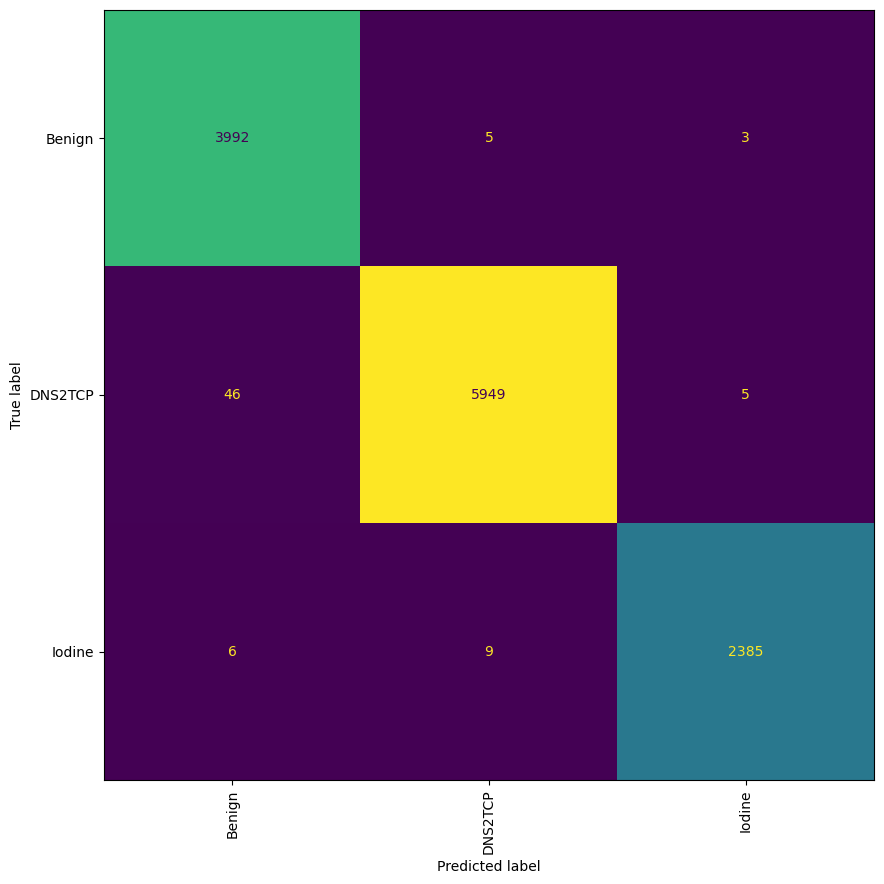

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
ConfusionMatrixDisplay.from_predictions(label_test, flow_pred, display_labels=CLASSES_LIST, xticks_rotation='vertical',
                                        ax=ax, colorbar=False)
plt.savefig(output_dir / 'ConfusionMatrix.pdf', bbox_inches="tight")

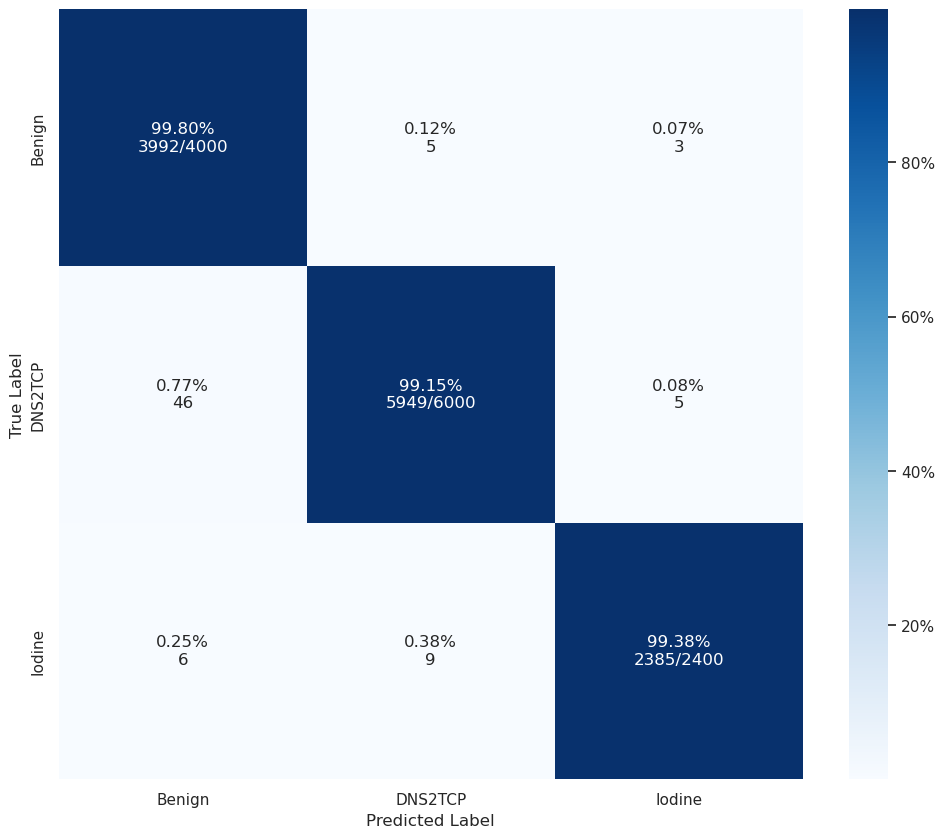

In [33]:
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


def cm_analysis(y_true, y_pred, filename, labels, classes, ymap=None, figsize=(17, 17)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      classes:   aliases for the labels. String array to be shown in the cm plot.
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    sns.set(font_scale=1)

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s[0])
            #elif c == 0:
            #    annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm = cm * 100
    cm.index.name = 'True Label'
    cm.columns.name = 'Predicted Label'
    fig, ax = plt.subplots(figsize=figsize)
    plt.yticks(va='center')

    sns.heatmap(cm, annot=annot, fmt='', ax=ax, xticklabels=classes, cbar=True, cbar_kws={'format': PercentFormatter()},
                yticklabels=classes, cmap="Blues")
    plt.savefig(filename, bbox_inches='tight')


cm_analysis(y_true=label_test, y_pred=flow_pred, filename=output_dir / 'ConfusionMatrix_nom.pdf', labels=[0, 1, 2],
            classes=CLASSES_LIST, figsize=(12, 10))

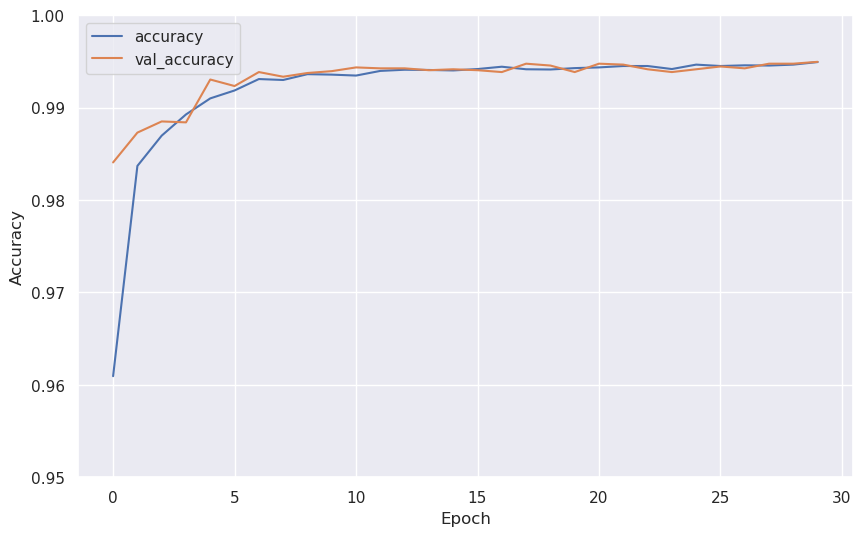

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(
    history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95, 1])
plt.savefig(output_dir / "normal_model_Accuracy.pdf")

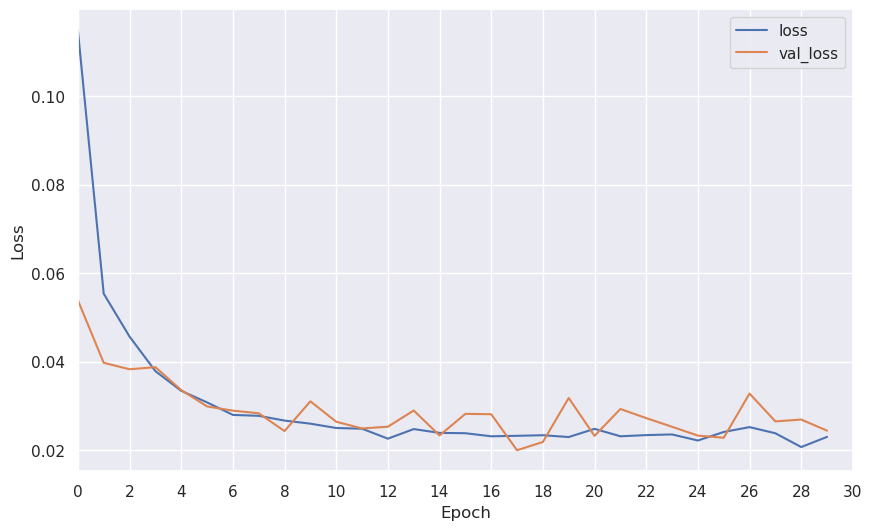

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim([0, EPOCHS])
plt.xticks(range(0, EPOCHS + 1, 2))
plt.savefig(output_dir / "normal_model_Loss.pdf")
